## Context

- sasha was interested if IFN-g signaling inhibits TFG-b signaling
- I discussed with eric that it might be interesting to compare early pseudotime components in the nonperturbed cells to those of the knockouts to see if there is any differential sensitivity
- i'm going to use the object generated in PAL014

## Libraries and Settings

In [26]:
import scanpy as sc
import decoupler as dc
from pydeseq2.dds import DefaultInference
from pydeseq2 import ds
import plotnine as p9
import numpy as np

## Import

In [2]:
rna = sc.read_h5ad("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/PAL0014.h5ad")
rna.obs = rna.obs.rename(columns = {"psuedotime":"pseudotime"})

## Inspect Pseudotime

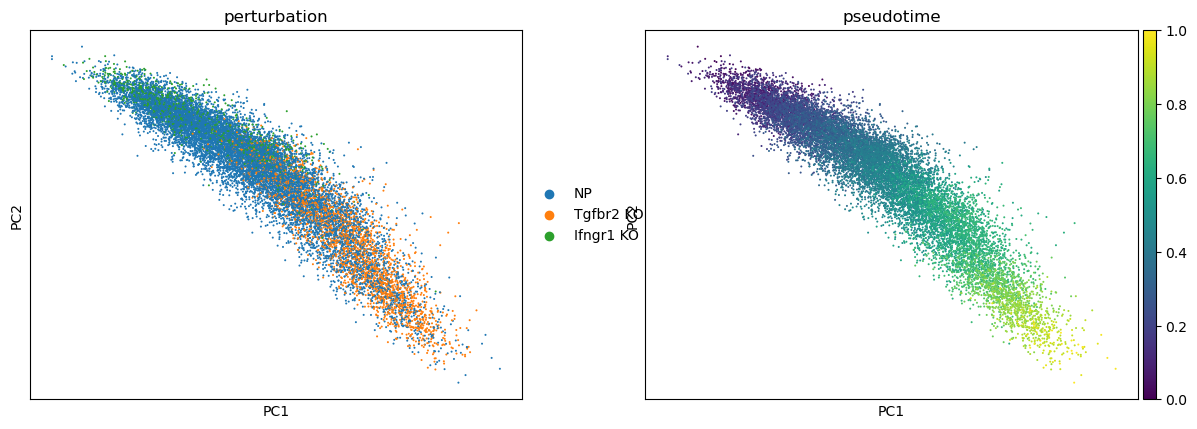

In [3]:
sc.pl.pca(rna, color = ["perturbation", "pseudotime"])

## Ifngr1 KO vs Eearly NP

### Subset on early pseudotime

In [107]:
early = rna[rna.obs.pseudotime.lt(0.1), :]

early = early[~early.obs.perturbation.eq("Tgfbr2 KO"), :]

### Pseudobulk

In [108]:
rna.obs.head()

,Classification,mixscape_class,perturbation,phase,CD62_cite,pseudotime
AAACCAAAGACGTTAT-1,mLN-CD62Lpos,Tgfbr2 KO,Tgfbr2 KO,G1,True,0.662730
AAACCAAAGATGAAGC-1,mLN-CD62Lpos,NT,NP,G1,True,0.524915
AAACCAAAGGTAGCTC-1,mLN-CD62Lpos,Ifngr1 KO,Ifngr1 KO,G1,True,0.071408
AAACCAGCAAAGCTTC-1,mLN-CD62Lpos,Tgfbr2 NP,NP,G1,True,0.372897
AAACCAGCAACAAGAT-1,mLN-CD62Lneg,NT,NP,G1,False,0.423137


In [109]:
pb = dc.get_pseudobulk(
    early, 
    sample_col="Classification",
    groups_col="perturbation",
    layer="counts", 
    min_cells=10,
    min_counts=1000
)

<Axes: ylabel='Count'>

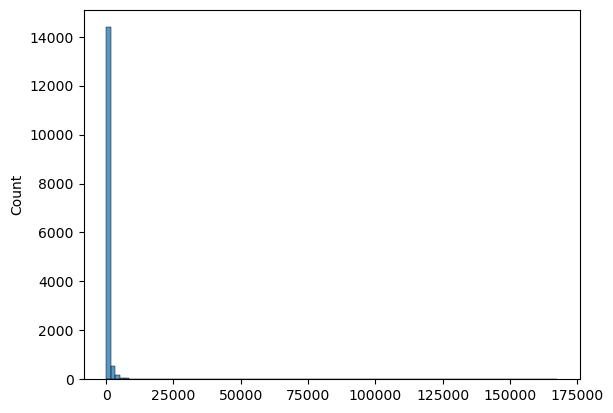

In [110]:
sns.histplot(data = pb.X.sum(axis = 0), bins = 100)

In [111]:
#pb = pb[:, (pb.X.sum(axis = 0) > 10000)]

### Differential Expression

In [112]:
dds = ds.DeseqDataSet(
    counts=pb.X,
    metadata=pb.obs,
    design_factors="perturbation",
    ref_level=["perturbation", "NP"],
    refit_cooks=True,
    inference=DefaultInference(n_cpus=4)
)

dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.10 seconds.

Fitting dispersion trend curve...
... done in 0.22 seconds.

Fitting MAP dispersions...
... done in 2.44 seconds.

Fitting LFCs...
... done in 2.59 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [113]:
stat_res = ds.DeseqStats(
    dds,
    contrast=["perturbation", 'Ifngr1 KO', 'NP'],
    inference=DefaultInference(n_cpus=4),
)

In [114]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: perturbation Ifngr1 KO vs NP
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0        0.052958        0.116249  3.894534  0.029849  0.976187       NaN
1        7.616460       -0.033279  0.602421 -0.055242  0.955946  0.999946
2        0.115825        0.719303  3.688227  0.195027  0.845372       NaN
3        4.776982        0.147325  0.677777  0.217365  0.827924  0.999946
4        2.801729       -0.265508  0.915228 -0.290100  0.771740  0.999946
...           ...             ...       ...       ...       ...       ...
15315  810.117512        0.164052  0.092103  1.781181  0.074883  0.999946
15316  989.107454        0.111247  0.069872  1.592157  0.111349  0.999946
15317  770.790104        0.086088  0.074754  1.151622  0.249476  0.999946
15318   35.802226       -0.075887  0.272708 -0.278272  0.780804  0.999946
15319  596.581991        0.312555  0.322187  0.970103  0.331995  0.999946

[15320 rows x 6 columns]


... done in 0.55 seconds.



In [115]:
stat_res.results_df.set_index(pb.var_names, inplace=True)

### Plot

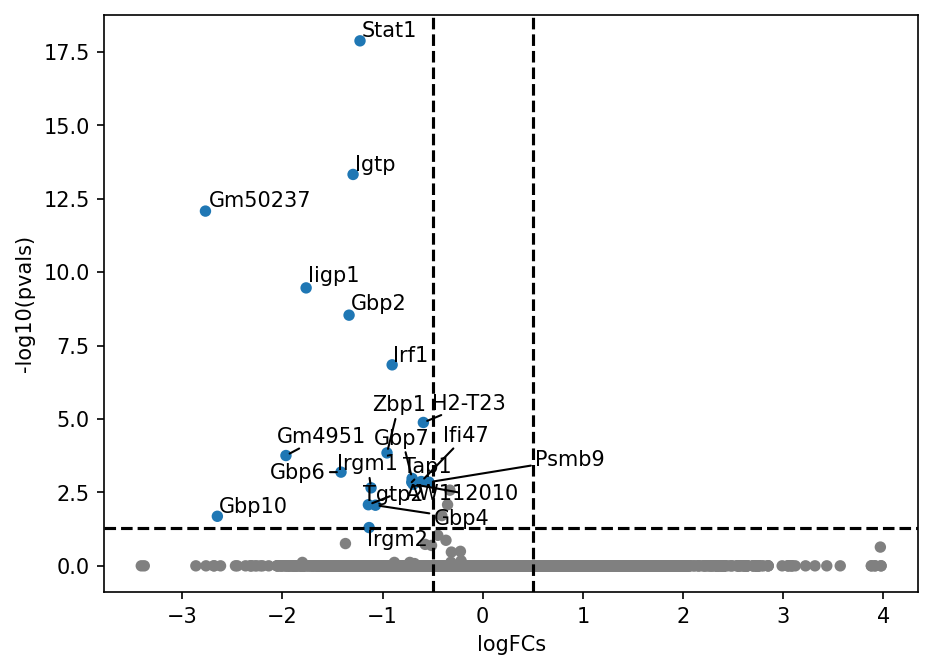

In [116]:
dc.plot_volcano_df(
    stat_res.results_df,
    x = "log2FoldChange",
    y = "padj",
    dpi=150,
    top=20
)

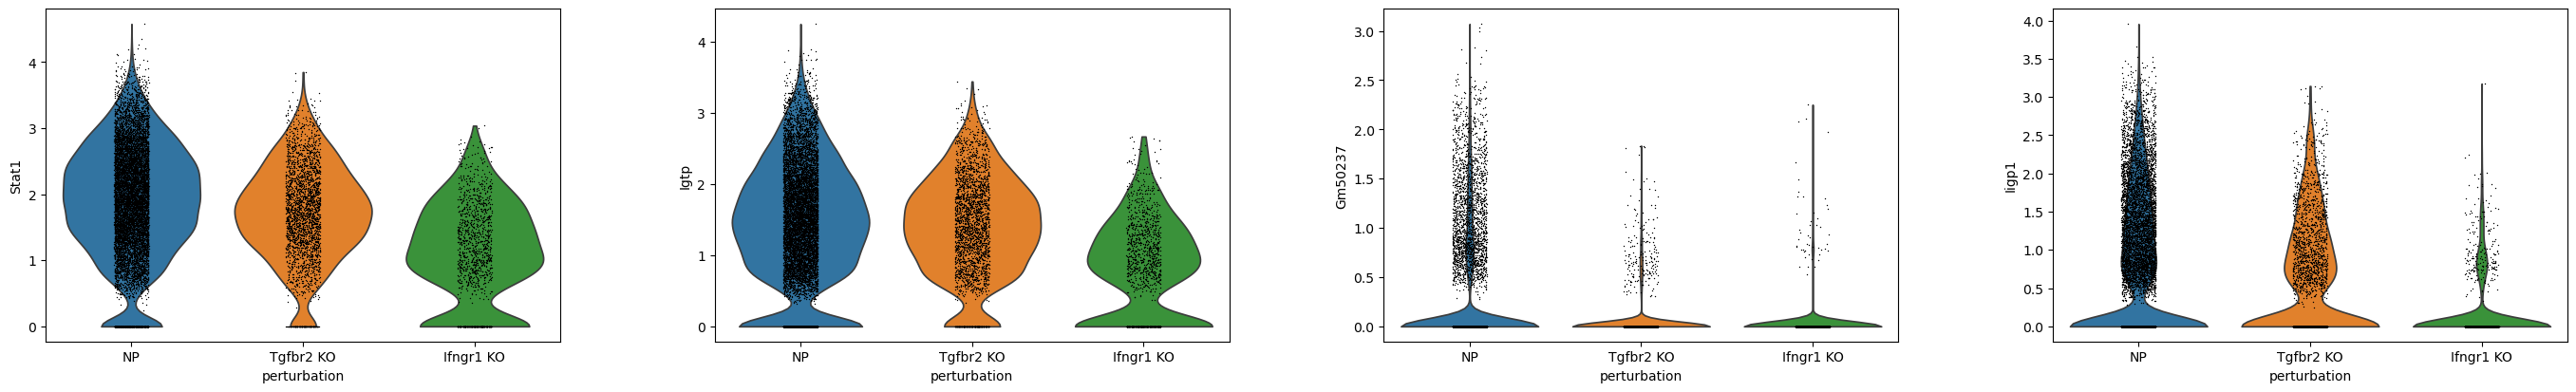

In [120]:
sc.pl.violin(rna, groupby="perturbation", keys = ["Stat1", "Igtp", "Gm50237", "Iigp1"])

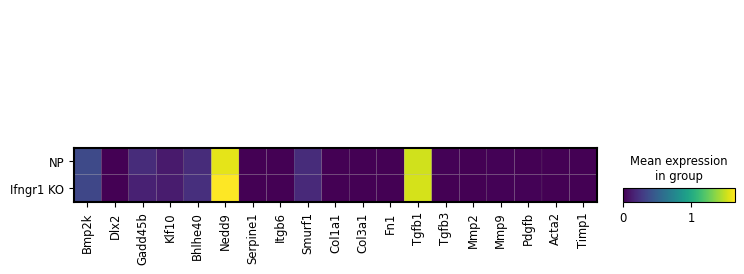

In [117]:
tgf_targets = [
    "Bmp2k",    # BMP-2 Inducible Kinase
    "Dlx2",     # Distal-Less Homeobox 2
    "Gadd45b",  # Growth Arrest and DNA-Damage-Inducible Beta
    "Klf10",    # Kruppel-Like Factor 10
    "Bhlhe40",  # Basic Helix-Loop-Helix Family Member E40
    "Nedd9",    # Neural Precursor Cell Expressed, Developmentally Down-Regulated 9
    "Serpine1", # Serpin Family E Member 1
    "Itgb6",    # Integrin Subunit Beta 6
    "Smurf1",   # SMAD Specific E3 Ubiquitin Protein Ligase 1
    "Col1a1",   # Collagen Type I Alpha 1 Chain
    "Col3a1",   # Collagen Type III Alpha 1 Chain
    "Fn1",      # Fibronectin 1
    "Tgfb1",    # Transforming Growth Factor Beta 1
    "Tgfb3",    # Transforming Growth Factor Beta 3
    "Mmp2",     # Matrix Metallopeptidase 2
    "Mmp9",     # Matrix Metallopeptidase 9
    "Pdgfb",    # Platelet-Derived Growth Factor Subunit B
    "Acta2",    # Actin Alpha 2, Smooth Muscle
    "Timp1"     # Tissue Inhibitor of Metalloproteinases 1
]

sc.pl.matrixplot(early, var_names=tgf_targets, groupby = "perturbation", layer = "counts")

## Tgfbr KO vs Late NP

### Subset on early pseudotime

In [96]:
early = rna[rna.obs.pseudotime.gt(0.8), :]

early = early[~early.obs.perturbation.eq("Ifngr1 KO"), :]

### Pseudobulk

In [97]:
rna.obs.head()

,Classification,mixscape_class,perturbation,phase,CD62_cite,pseudotime
AAACCAAAGACGTTAT-1,mLN-CD62Lpos,Tgfbr2 KO,Tgfbr2 KO,G1,True,0.662730
AAACCAAAGATGAAGC-1,mLN-CD62Lpos,NT,NP,G1,True,0.524915
AAACCAAAGGTAGCTC-1,mLN-CD62Lpos,Ifngr1 KO,Ifngr1 KO,G1,True,0.071408
AAACCAGCAAAGCTTC-1,mLN-CD62Lpos,Tgfbr2 NP,NP,G1,True,0.372897
AAACCAGCAACAAGAT-1,mLN-CD62Lneg,NT,NP,G1,False,0.423137


In [98]:
pb = dc.get_pseudobulk(
    early, 
    sample_col="Classification",
    groups_col="perturbation",
    layer="counts", 
    min_cells=10,
    min_counts=1000
)

<Axes: ylabel='Count'>

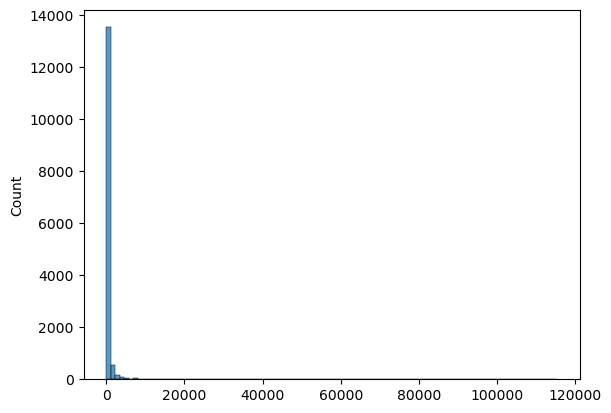

In [99]:
sns.histplot(data = pb.X.sum(axis = 0), bins = 100)

In [100]:
#pb = pb[:, (pb.X.sum(axis = 0) > 10000)]

### Differential Expression

In [101]:
dds = ds.DeseqDataSet(
    counts=pb.X,
    metadata=pb.obs,
    design_factors="perturbation",
    ref_level=["perturbation", "NP"],
    refit_cooks=True,
    inference=DefaultInference(n_cpus=4)
)

dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.79 seconds.

Fitting dispersion trend curve...
... done in 0.21 seconds.

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/scanpy/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 2.53 seconds.

Fitting LFCs...
... done in 1.86 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [102]:
stat_res = ds.DeseqStats(
    dds,
    contrast=["perturbation", 'Tgfbr2 KO', 'NP'],
    inference=DefaultInference(n_cpus=4),
)

In [103]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: perturbation Tgfbr2 KO vs NP
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0         0.678359        1.250140  3.893164  0.321112  0.748126       NaN
1        12.780018        0.439417  0.652386  0.673553  0.500595  0.999717
2         0.203726       -0.579819  4.734795 -0.122459  0.902535       NaN
3         9.612738        0.305063  0.769247  0.396574  0.691682  0.999717
4         6.995202        0.111192  0.947909  0.117302  0.906621  0.999717
...            ...             ...       ...       ...       ...       ...
14460   537.907866        0.141637  0.147456  0.960537  0.336785  0.999717
14461   604.369089       -0.013146  0.147109 -0.089365  0.928792  0.999717
14462   471.353031        0.215469  0.155685  1.384010  0.166355  0.999717
14463    46.114501        0.029720  0.351085  0.084652  0.932538  0.999717
14464  1293.717749       -0.057230  0.141710 -0.403854  0.686320  0.999717

[14465 rows x 6 columns]


... done in 0.53 seconds.



In [104]:
stat_res.results_df.set_index(pb.var_names, inplace=True)

### Plot

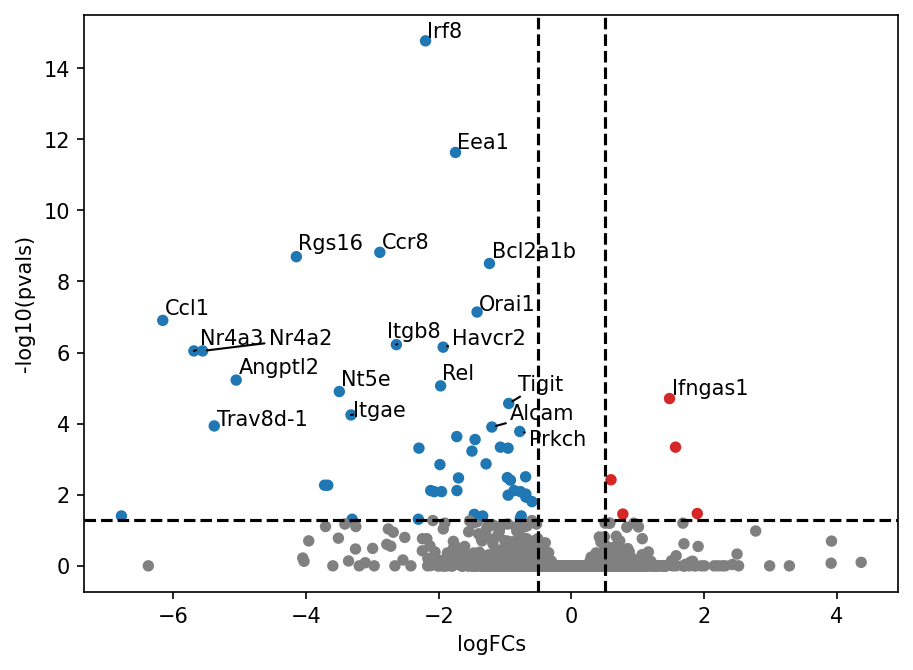

In [105]:
dc.plot_volcano_df(
    stat_res.results_df,
    x = "log2FoldChange",
    y = "padj",
    dpi=150,
    top=20
)

## Conclusions

- it seems that most of the upregulated genes are common, but there are certain genes that are not downregulated